In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os


!pip install scikit_optimize
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

from sklearn.impute import SimpleImputer
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, accuracy_score
!pip install -U mlxtend
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, regularizers
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import CuDNNGRU, Dense, BatchNormalization, Dropout, CuDNNLSTM, Flatten
print(tf.__version__)
print(tf.keras.__version__)

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.6/dist-packages (0.17.0)
1.15.0
2.2.4-tf


In [0]:
def load(path):
    from google.colab import drive
    drive.mount('/gdrive')
    data_dir = '/gdrive/My Drive/Studia/INZYNIERKA/StockPricePrediction/data/'
    with open(data_dir + path, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [0]:
def save(path, data):
    from google.colab import drive
    drive.mount('/gdrive')
    data_dir = '/gdrive/My Drive/Studia/INZYNIERKA/StockPricePrediction/data/'
    with open(data_dir + path, 'wb') as handle:
        pickle.dump(data, handle)

In [0]:
model_path = '/gdrive/My Drive/Studia/INZYNIERKA/StockPricePrediction/models/dense.hdf5'
best_model_path = '/gdrive/My Drive/Studia/INZYNIERKA/StockPricePrediction/models/dense_BayOpt.hdf5'

In [47]:
# Load data
train_x, train_y, val_x, val_y, test_x, test_y = load('input/data_lookback_1.pickle')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Hiperparameters and their ranges
dim_learning_rate = Real(low=1e-5, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=16, high=128, name='num_dense_nodes')
dim_dropout_rate = Real(low=0, high=0.5, name='dropout_rate')

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_dropout_rate]

default_parameters = [1e-3, 3, 64, 0.1]

best_accuracy = 0.0
best_history = None

In [0]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, dropout_rate, input_shape):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    
    # Start construction of a Keras Sequential model.
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(num_dense_nodes,
                        kernel_regularizer=regularizers.l2(),
                        activation='relu',
                        name=name))
        model.add(Dropout(dropout_rate))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(1, activation='sigmoid'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, dropout_rate):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    global i
    print('index', i)
    i += 1

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('dropout_rate:', dropout_rate)
    verbose = 0
    
    
    es = callbacks.EarlyStopping(monitor='val_loss', verbose=verbose, patience=20, min_delta=0.0001) 
    mc = callbacks.ModelCheckpoint(model_path, monitor='val_acc', verbose=verbose, save_best_only=True)

    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         dropout_rate=dropout_rate,
                         input_shape=train_x.shape[-2:])
    
       
    # print(model.summary())

    # Use Keras to train the model.
    with tf.device('/gpu:0'):  
        history = model.fit(train_x, train_y, epochs=150, verbose=verbose, validation_data=(val_x, val_y), batch_size=32, callbacks=[es, mc],
                            validation_steps=100)


    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    model = load_model(model_path)
    predictions = model.predict(test_x)
    predictions = (predictions > 0.5)
    accuracy = accuracy_score(test_y, predictions)
    print('Highest validation accuracy: {0:.2%}'.format(max(history.history['val_acc'])))

    # Print the classification accuracy.
    print("Accuracy: {0:.2%}".format(accuracy))
    print()
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy
    global best_history

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(best_model_path)
        
        # Update the classification accuracy.
        best_accuracy = accuracy
        best_history = history

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    tf.keras.backend.clear_session()
    tf.reset_default_graph()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [46]:
i = 0
fitness(x=default_parameters)

index 0
learning rate: 1.0e-03
num_dense_layers: 3
num_dense_nodes: 64
dropout_rate: 0.1
Highest validation accuracy: 54.07%
Accuracy: 51.16%




-0.5116279069767442

In [31]:
i = 0
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=50,
                            x0=default_parameters)

index 0
learning rate: 1.0e-03
num_dense_layers: 3
num_dense_nodes: 64
dropout_rate: 0.1
Highest validation accuracy: 80.23%
Accuracy: 69.19%


index 1
learning rate: 1.5e-05
num_dense_layers: 5
num_dense_nodes: 58
dropout_rate: 0.11214487689795691
Highest validation accuracy: 68.02%
Accuracy: 59.30%


index 2
learning rate: 8.5e-05
num_dense_layers: 3
num_dense_nodes: 40
dropout_rate: 0.34583144413279077
Highest validation accuracy: 77.91%
Accuracy: 68.60%


index 3
learning rate: 3.2e-05
num_dense_layers: 4
num_dense_nodes: 102
dropout_rate: 0.27834020450336017
Highest validation accuracy: 76.16%
Accuracy: 66.86%


index 4
learning rate: 1.2e-05
num_dense_layers: 5
num_dense_nodes: 66
dropout_rate: 0.366310080017986
Highest validation accuracy: 49.42%
Accuracy: 51.16%


index 5
learning rate: 1.7e-03
num_dense_layers: 1
num_dense_nodes: 111
dropout_rate: 0.4444597225291423
Highest validation accuracy: 80.81%
Accuracy: 69.77%


index 6
learning rate: 2.7e-05
num_dense_layers: 3
num_de

In [32]:
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'dropout_rate']
# best params
best_params = search_result.x
for k, v in zip(dim_names, best_params):
    print(k, ' -> ', v)

# highest accuracy value on test set
acc = round(-1 *search_result.fun, 2)
print('Best accuracy -> ', acc)

learning_rate  ->  0.007123579943457989
num_dense_layers  ->  4
num_dense_nodes  ->  128
dropout_rate  ->  0.0
Best accuracy ->  0.74


<Figure size 1440x1440 with 0 Axes>

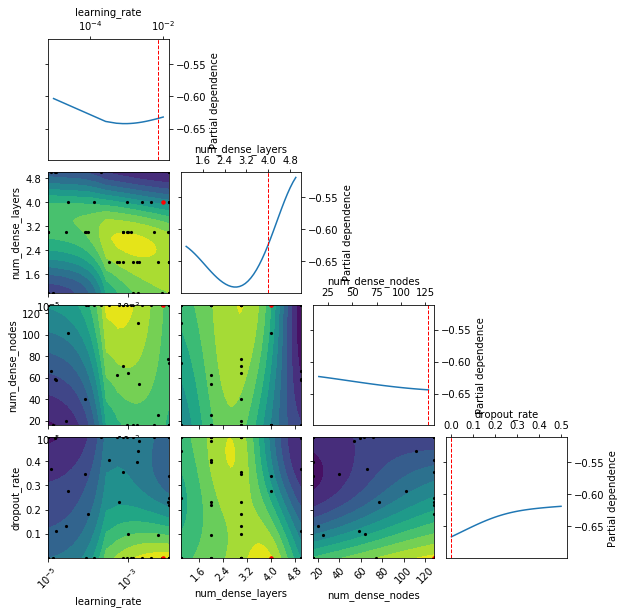

In [33]:
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 20))
_ = plot_objective(result=search_result, dimensions=dim_names)

<Figure size 1440x1440 with 0 Axes>

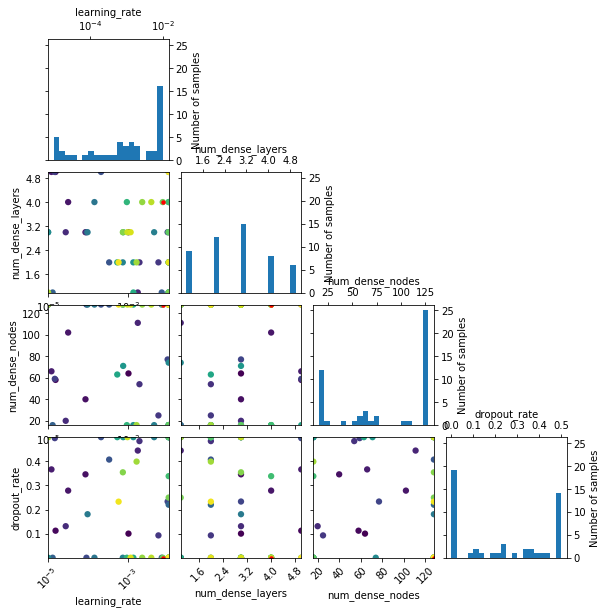

In [34]:
fig1 = plt.figure(figsize=(20, 20))
_ = plot_evaluations(search_result, dimensions=dim_names)

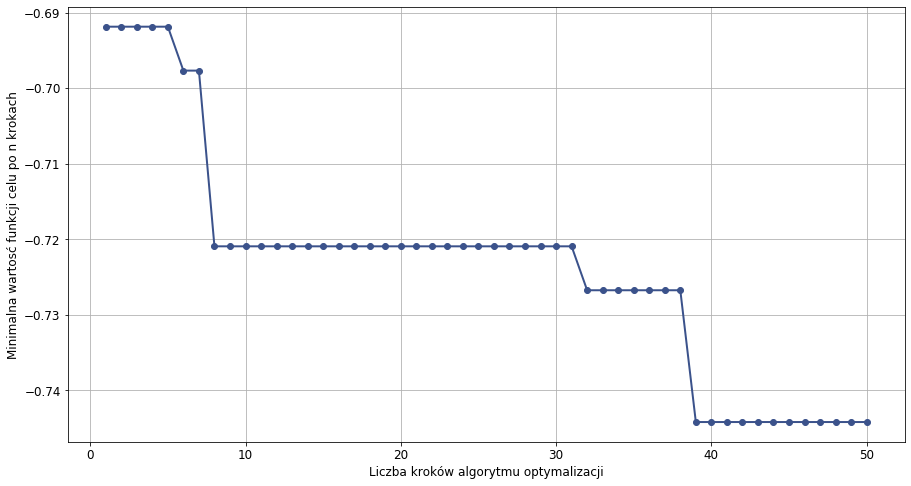

In [35]:
plt.rcParams.update({'font.size': 12})
fig2 = plt.figure(figsize=(15, 8))
_ = plot_convergence(search_result)
_ = plt.ylabel('Minimalna wartosć funkcji celu po n krokach')
_ = plt.xlabel('Liczba kroków algorytmu optymalizacji')
_ = plt.title('')

In [0]:
# train_x, train_y, val_x, val_y, test_x, test_y = build_data(lookback=lookback, step=1)

In [36]:
model = load_model(best_model_path)
print(model.summary())
predictions = model.predict(test_x)
predictions = (predictions > 0.5)
predictions = [int(pred) for pred in predictions]
prec = precision_score(test_y, predictions)
rec = recall_score(test_y, predictions)
acc = accuracy_score(test_y, predictions)

print(f"Accuracy: {round(acc * 100,2)}%")
print(f"precision: {round(prec * 100,2)}%")
print(f"recall: {round(rec * 100,2)}%")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 35)                0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 128)               4608      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer_dense_2 (Dense)        (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
layer_dense_3 (Dense)        (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

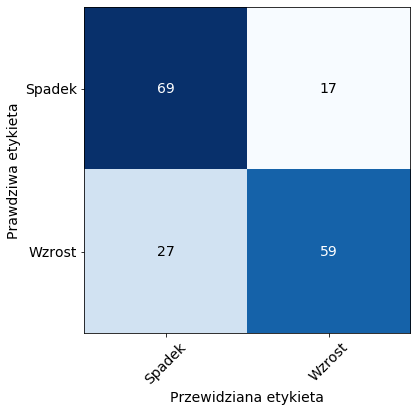

In [37]:
plt.rcParams.update({'font.size': 14})
cm = confusion_matrix(y_target=test_y, 
                    y_predicted=predictions)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                class_names=['Spadek', 'Wzrost'],
                                figsize=(6,6))
_ = plt.ylabel('Prawdziwa etykieta')
_ = plt.xlabel('Przewidziana etykieta')

In [38]:
model.evaluate(test_x, test_y, steps=100)

100/100 [==============================] - 0s 2ms/step - loss: 0.7479 - acc: 0.7442


[0.7479174733161926, 0.74418604]

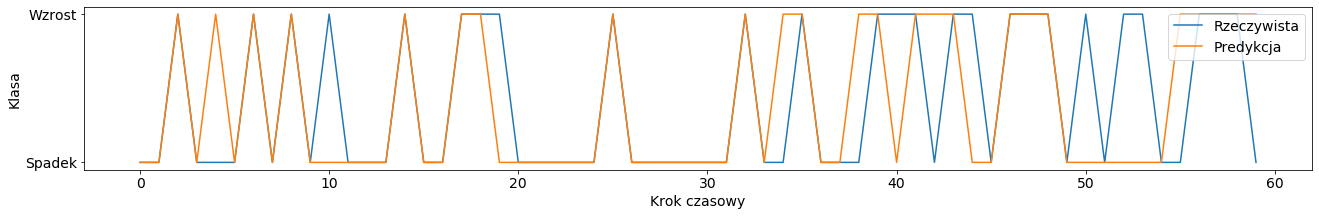

In [42]:
def plot_predictions(length=60):
    fig = plt.figure(figsize=(22,3))
    plt.plot(test_y[:length])
    plt.plot(np.array(predictions)[:length])
    plt.legend(['Rzeczywista', 'Predykcja'], loc=1)
    plt.xlabel('Krok czasowy')
    plt.ylabel('Klasa')
    plt.yticks([0, 1], ['Spadek', 'Wzrost'])

plot_predictions()

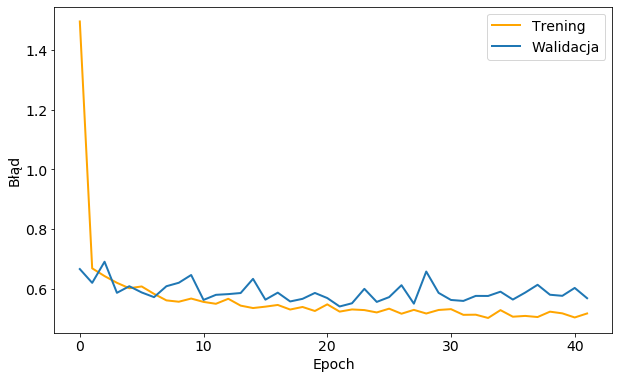

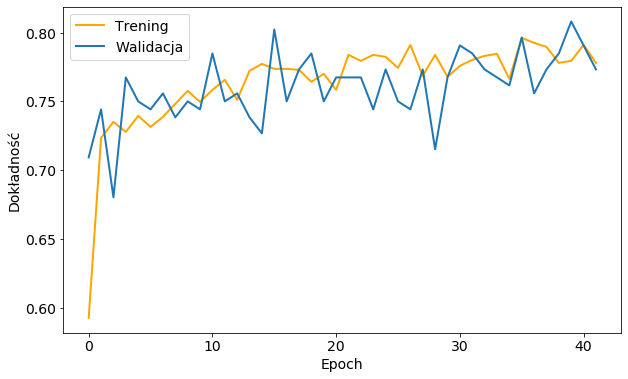

In [43]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure(figsize=(10, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Błąd')
    plt.plot(hist['epoch'], hist['loss'], linewidth=2, color='orange',
            label='Trening')
    plt.plot(hist['epoch'], hist['val_loss'], linewidth=2,
            label = 'Walidacja')
    plt.legend()

    plt.figure(figsize=(10, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Dokładność')
    plt.plot(hist['epoch'], hist['acc'], linewidth=2, color='orange',
            label='Trening')
    plt.plot(hist['epoch'], hist['val_acc'], linewidth=2,
            label = 'Walidacja')
    plt.legend()

plot_history(best_history)

In [27]:
print(len(predictions))
save('predictions/dense.pickle', predictions)

172
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
